# Проект по созданию нейронной сети для прогнозирование температуры звезды.

## Цели исследования :

- Построение нейронной сети для обсерватории «Небо на ладони» , с целью предсказания температуры обнаруженной звезды на основании поступивших данных.

## Ход исследования :

- Загрузка и изучение поступивших данных.

- Поиск и обработка дефектов в данных.

- Построение простой модели нейронной сети (baseline).

- Корректировка параметров сети с целью улучшения метрик предсказания.

- Финальный вывод и рекомендации.

## Описание поступивших признаков.

**Датасеты**

*   **6_class.csv**:
    
    
    *   `relative_luminosity` (`L/L☉`) — светимость звезды относительно Солнца
    *   `relative_radius` (`R/R☉`) — радиус звезды относительно радиуса Солнца  
    *   `absolute_magnitude` (`Mv`) — абсолютная звёздная величина
    *   `star_color` — цвет звезды (`white`, `red`, `blue`, `yellow`, `yellow-orange`)
    *   `star_type` — тип звезды
    *   `absolute_temperature` (`T, K`) — температура в Кельвинах

## Технический модуль.

### Импорт библиотек и определение констант.

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import phik
import warnings
import time
import math
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
RS = 42
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
%matplotlib inline 

### Импорт функций.

In [6]:
sns.set_style('whitegrid')
sns.set_palette('RdYlBu')
def df_info(df, name="df"):
    """
    Выводит информацию о DataFrame: info(), describe() и первые 10 строк
    
    Parameters:
    df (pd.DataFrame): DataFrame для анализа
    name (str): имя DataFrame для отображения (по умолчанию "df")
    """
    print(f"=== ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ '{name}' ===")
    print(f"Размер: {df.shape[0]} строк, {df.shape[1]} столбцов")
    print()
    
    print("1. ИНФОРМАЦИЯ О ДАННЫХ (info()):")
    display(df.info())
    print()
    
    print("2. СТАТИСТИЧЕСКОЕ ОПИСАНИЕ (describe().T):")
    display(df.describe().T)
    print()
    
    print("3. ПЕРВЫЕ 10 СТРОК:")
    display(df.head(10))
    print("="*60)

In [7]:
def check_data_dubmiss(df, df_name='DataFrame'):
    """
    Анализирует DataFrame на дубликаты и пропущенные значения.
    Возвращает единый отчет в виде DataFrame с категориями.

    Параметры:
    - df: pandas DataFrame для проверки
    - df_name: название DataFrame для отчета

    Возвращает:
    - Единый DataFrame с отчетом
    """
    report_parts = []

    # 1. Общая информация
    info_df = pd.DataFrame({
        'Категория': ['Общая информация'],
        'Параметр': ['Название датафрейма'],
        'Значение': [df_name],
        'Детали': [f'Размер : {df.shape[0]} x {df.shape[1]}']
    })
    report_parts.append(info_df)

    # 2. Дубликаты
    duplicates = df.duplicated().sum()
    duplicates_df = pd.DataFrame({
        'Категория': ['Дубликаты', 'Дубликаты'],
        'Параметр': ['Всего дубликатов', 'Примеры дубликатов'],
        'Значение': [duplicates, duplicates > 0],
        'Детали': ['', f"Первые {min(5, duplicates)} примеров" if duplicates > 0 else '']
    })
    report_parts.append(duplicates_df)

    # 3. Пропущенные значения по столбцам
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    if missing.sum() > 0:
        missing_df = pd.DataFrame({
            'Категория': ['Пропущенные значения'] * len(missing),
            'Параметр': missing.index,
            'Значение': missing.values,
            'Детали': [f"{pct:.2f}%" for pct in missing_pct.values]
        })
        missing_df = missing_df[missing_df['Значение'] > 0]
        report_parts.append(missing_df)

    # 4. Итог по пропущенным значениям
    total_missing_df = pd.DataFrame({
        'Категория': ['Пропуски'],
        'Параметр': ['Всего пропущенных значений'],
        'Значение': [missing.sum()],
        'Детали': [f"{missing.sum() / df.size:.2%} от всех ячеек"]
    })
    report_parts.append(total_missing_df)

    report = pd.concat(report_parts, ignore_index=True)

    if duplicates > 0:
        duplicates_examples = df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist()).head()
        report.at[4, 'Детали'] = str(duplicates_examples.to_dict('records'))

    return report

In [8]:
def graph_num(df, columns, title, xlabel, bins=30):
    """
    Визуализирует числовые данные с помощью гистограммы и boxplot.

    Параметры:
    -----------
    df : pandas.DataFrame
        DataFrame, содержащий данные для анализа.
    columns : str
        Название столбца с числовыми данными, которые будут визуализированы.
    title : str
        Заголовок графика (добавляется к описанию гистограммы и boxplot).
    xlabel : str
        Подпись оси X для гистограммы.
    bins : int, optional
        Количество интервалов (бинов) для гистограммы. По умолчанию 30.

    
    """
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    sns.histplot(data=df, x=columns, kde=True, color='blue', bins=bins, ax=ax[0])
    ax[0].set_title('Гистограмма признака '+ title)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('Кол-во')
    
    sns.boxplot(data=df[columns], orient='h', ax=ax[1])
    ax[1].set_title('Разброс значений признака '+ title)
    ax[1].set_xlabel('Значения')
    ax[1].set_ylabel(' ')

## Загрузка и первичное ознакомление с данными.

In [9]:
try:
    df = pd.read_csv('6_class_saved.csv')
except:
    df = df = pd.read_csv('/datasets/6_class.csv')


In [10]:
df_info(df, name = '6_class_saved')

=== ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ '6_class_saved' ===
Размер: 240 строк, 7 столбцов

1. ИНФОРМАЦИЯ О ДАННЫХ (info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


None


2. СТАТИСТИЧЕСКОЕ ОПИСАНИЕ (describe().T):


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,240.0,119.500000,69.426220,0.00000,59.750000,119.5000,179.2500,239.00
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
Luminosity(L/Lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
Radius(R/Ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
Absolute magnitude(Mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
Star type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00



3. ПЕРВЫЕ 10 СТРОК:


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
5,5,2840,0.000650,0.1100,16.98,0,Red
6,6,2637,0.000730,0.1270,17.22,0,Red
7,7,2600,0.000400,0.0960,17.40,0,Red
8,8,2650,0.000690,0.1100,17.45,0,Red
9,9,2700,0.000180,0.1300,16.05,0,Red


In [11]:
ProfileReport(df, title="Profiling Report", minimal=False, progress_bar=False)

100%|██████████| 7/7 [00:00<00:00, 221.02it/s]


В ходе обзорного анализа обнаружилось несоответствие названия переменных принятому стандарту.

### Приведение названия переменных к стандартизированному виду.

In [12]:
df.columns

Index(['Unnamed: 0', 'Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [13]:
df.columns = ['Unnamed: 0','temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']

In [14]:
df.columns

Index(['Unnamed: 0', 'temperature', 'luminosity', 'radius',
       'absolute_magnitude', 'star_type', 'star_color'],
      dtype='object')

### Вывод

- Был обнаружен столбец *Unnamed: 0* который полностью дублирует индексацию реализованную в pandas , решим эту проблему на этапе предобработки.

- В данных наблюдается сильный перекос в сторону нулевых значений в переменных **Luminosity(L/Lo), Radius(R/Ro) и Temperature (K)** , рассмотрим возможность таких значений нижу в блоке предобработки.

## Предобработка данных.

**Прежде всего создадим контрольную копию датасета , для контроля размерности в ходен обработки признаков.**

In [15]:
df_res = df.copy()
df_res.shape

(240, 7)

### Проверка на явные дубликаты.

In [16]:
check_data_dubmiss(df, '6_class')

,Категория,Параметр,Значение,Детали
0,Общая информация,Название датафрейма,6_class,Размер : 240 x 7
1,Дубликаты,Всего дубликатов,0,
2,Дубликаты,Примеры дубликатов,False,
3,Пропуски,Всего пропущенных значений,0,0.00% от всех ячеек


### Удаление столбца **Unnamed: 0**

Столбец Unnamed: 0 является избыточным, так как дублирует встроенный индекс pandas , удалим его.

In [17]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.shape

(240, 6)

### Преобразование значений star_color

При ознакомлении с данными в признаке *star_color* были обнаружены дефекты и  *смысловые* дубликаты в данных.

In [18]:
df.star_color.unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [19]:
df['star_color'] = df['star_color'].str.replace(r'[\s-]', '_', regex=True).str.rstrip('_').str.lower()

In [20]:
df.star_color.unique()

array(['red', 'blue_white', 'white', 'yellowish_white',
       'pale_yellow_orange', 'blue', 'whitish', 'yellow_white', 'orange',
       'white_yellow', 'yellowish', 'orange_red'], dtype=object)

In [21]:
df.star_color.value_counts()

star_color
red                   112
blue                   56
blue_white             41
white                  10
yellow_white            8
yellowish_white         3
yellowish               3
whitish                 2
orange                  2
pale_yellow_orange      1
white_yellow            1
orange_red              1
Name: count, dtype: int64

In [22]:
df.star_color.replace({
    'yellowish_white' : 'yellow_white',
            'whitish' : 'white',
            'orange_red' : 'red',
            'pale_yellow_orange' : 'orange',
            'white_yellow': 'yellow_white'}, inplace=True)

/tmp/ipykernel_329/1791280282.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.star_color.replace({


In [23]:
df.star_color.value_counts()

star_color
red             113
blue             56
blue_white       41
white            12
yellow_white     12
orange            3
yellowish         3
Name: count, dtype: int64

### Приведение к подхлдящему типу данных.

In [24]:
df[['star_color', 'star_type']] = df[['star_color', 'star_type']].astype('category')

### Детальное ознакомление с признаками **Luminosity(L/Lo), Radius(R/Ro) и Temperature (K)**

#### <span style="font-size:30px">**luminosity**</span>



На этапе первичного ознакомления мы заметили аномальное смещение значений стремящихся к нулю , изучим их подробней.

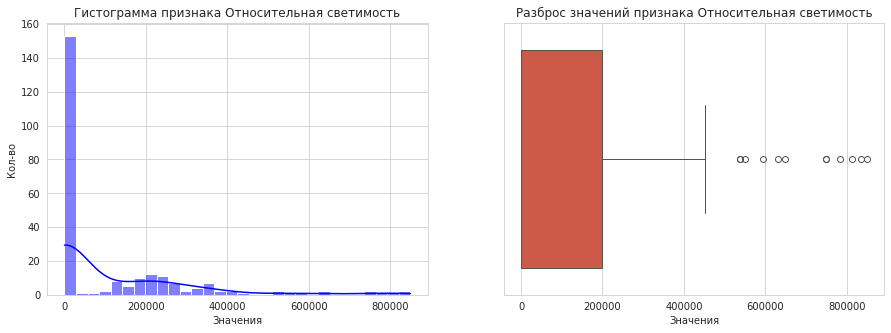

In [25]:
graph_num(df, 'luminosity', 'Относительная светимость', 'Значения')

Рассмотрим значения переменной более детально , разбив весь диапазон на 10 перцентилей.

In [26]:
quantiles = df['luminosity'].quantile(np.linspace(0, 1, 11))
print(quantiles)

0.0         0.000080
0.1         0.000338
0.2         0.000670
0.3         0.001100
0.4         0.002820
0.5         0.070500
0.6      1109.600000
0.7    146500.000000
0.8    225624.000000
0.9    333268.000000
1.0    849420.000000
Name: luminosity, dtype: float64


<span style="font-size:30px">**Изучив открытые астрономические источники мы обнаружили что :**</span>


<span style="font-size:30px">**Относительная светимость звезд различных типов (L/L☉)**</span>

**Относительная светимость L/L☉** — это светимость звезды относительно Солнца, где L☉ = 1.

<span style="font-size:30px">**Подробное описание по типам**</span>

---------------------------

<span style="font-size:20px">**Коричневый карлик (тип 0)**</span>
*   **Относительная светимость (L/L☉):** От ~0.000001 (10⁻⁶) до ~0.0001 (10⁻⁴)
*   **Объяснение:** Коричневые карлики — это несостоявшиеся звёзды. В их недрах не идут устойчивые термоядерные реакции синтеза водорода. Они светятся очень тускло за счёт медленного гравитационного сжатия и остаточного тепла.

<span style="font-size:20px">**Красный карлик (тип 1)**</span>
*   **Относительная светимость (L/L☉):** От ~0.0001 (10⁻⁴) до ~0.08
*   **Объяснение:** Самые распространённые и долгоживущие звёзды. Экономно расходуют водородное топливо благодаря медленному течению реакций.

<span style="font-size:20px">**Белый карлик (тип 2)**</span>
*   **Относительная светимость (L/L☉):** От ~0.0001 (10⁻⁴) до ~100
*   **Объяснение:** Остатки звёзд, которые не производят энергию, а медленно остывают, излучая запасённое тепло. Имеют огромную плотность и очень горячую поверхность.

<span style="font-size:20px">**Звёзды главной последовательности (тип 3)**</span>
*   **Относительная светимость (L/L☉):** От ~0.0001 (10⁻⁴) до ~1 000 000
*   **Объяснение:** Звёзды, в ядрах которых идёт синтез водорода в гелий. Светимость резко растёт с увеличением массы:
    *   **Красные карлики (M):** ≈ 0.0001 – 0.08
    *   **Оранжевые карлики (K):** ≈ 0.08 – 0.6
    *   **Жёлтые карлики (G):** ≈ 0.6 – 1.5 (Солнце = 1)
    *   **Белые звёзды (A):** ≈ 5 – 25 (Сириус А = 25 L☉)
    *   **Голубые звёзды (O, B):** ≈ 10 000 – 1 000 000+

<span style="font-size:20px">**Сверхгигант (тип 4)**</span>
*   **Относительная светимость (L/L☉):** От ~1 000 до ~500 000
*   **Объяснение:** Массивные звёзды, завершающие свой жизненный путь. Их огромная площадь поверхности делает их невероятно яркими, несмотря на относительно низкую температуру (у красных сверхгигантов).

<span style="font-size:20px">**Гипергигант (тип 5)**</span>
*   **Относительная светимость (L/L☉):** От ~500 000 до **~5 000 000 и более**
*   **Объяснение:** Самые массивные и яркие звёзды во Вселенной. Находятся на грани теоретического предела Эддингтона. Их жизнь коротка и заканчивается вспышкой гиперновой.

> **Важное примечание:** Внутри каждого типа, особенно среди звёзд главной последовательности, существует значительный разброс параметров. Приведённые значения являются типичными или усреднёнными диапазонами.


---

**Диапазоны светимости по типам звезд**

| Тип звезды | Номер | Относительная светимость (L/L☉) | Примеры |
| :--- | :---: | :--- | :--- |
| **Коричневый карлик** | 0 | 10⁻⁶ – 10⁻⁴ | WISE 0855-0714 |
| **Красный карлик** | 1 | 10⁻⁴ – 0.08 | Проксима Центавра, TRAPPIST-1 |
| **Белый карлик** | 2 | 10⁻⁴ – 100 | Сириус B, Процион B |
| **Звёзды главной последовательности** | 3 | 10⁻⁴ – 10⁶ | **Солнце (1)**, Сириус А (25) |
| **Сверхгигант** | 4 | 10³ – 5×10⁵ | Бетельгейзе (~120 000), Ригель |
| **Гипергигант** | 5 | 5×10⁵ – 5×10⁶+ | R136a1 (~6 200 000), Эта Киля |

---


<span style="font-size:30px">**Вывод :**</span>

- **Эта информация дает нам понять что такой разброс значений в целом допустим для астрономической сферы.**


#### <span style="font-size:30px">**radius**</span>



Значения относительного радиуса , так же показались подозрительными при первичном рассмотрении.

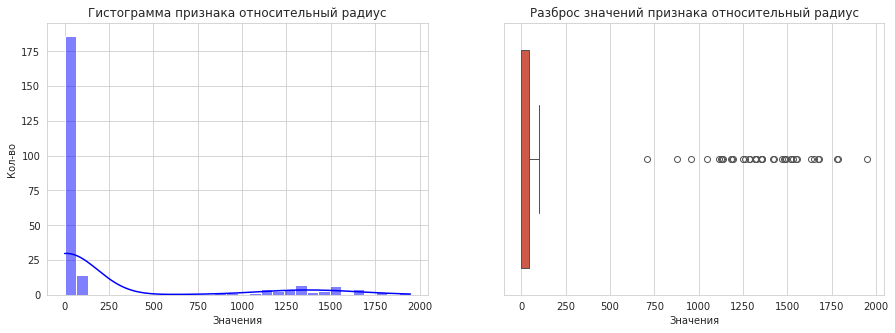

In [27]:
graph_num(df, 'radius', 'относительный радиус', 'Значения')

In [28]:
print(df['radius'].quantile(np.linspace(0, 1, 11)))

0.0       0.00840
0.1       0.01100
0.2       0.09174
0.3       0.12450
0.4       0.30060
0.5       0.76250
0.6       6.00320
0.7      24.30000
0.8      83.00000
0.9    1315.90000
1.0    1948.50000
Name: radius, dtype: float64


<span style="font-size:30px">**Аналогичное изучение астрономической информации про относительный радиус звезд , показало :**</span>

<span style="font-size:25px">**Подробное описание по типам звезд**</span>

<span style="font-size:20px">**Коричневые карлики (типы 0.0-0.1)**</span>
*   **Относительный радиус (R/R☉):** 0.0084 - 0.0110
*   **Объяснение:** Чрезвычайно компактные объекты, лишь немногим больше Юпитера. Их небольшие размеры соответствуют недостаточной массе для запуска полноценных термоядерных реакций.

<span style="font-size:20px">**Красные карлики (типы 0.2-0.4)**</span>
*   **Относительный радиус (R/R☉):** 0.09 - 0.30
*   **Объяснение:** Небольшие, но полноценные звезды. Их компактные размеры способствуют медленному расходу топлива и чрезвычайно долгой жизни.

<span style="font-size:20px">**Солнцеподобные звезды (тип 0.5)**</span>
*   **Относительный радиус (R/R☉):** 0.76
*   **Объяснение:** Звезды, близкие по характеристикам к Солнцу. Их радиус делает их идеальными кандидатами для поиска землеподобных планет.

<span style="font-size:20px">**Субгиганты (тип 0.6)**</span>
*   **Относительный радиус (R/R☉):** 6.00
*   **Объяснение:** Звезды, завершающие стадию главной последовательности. Они начинают расширяться по мере исчерпания водорода в ядре.

<span style="font-size:20px">**Гиганты (типы 0.7-0.8)**</span>
*   **Относительный радиус (R/R☉):** 24 - 83
*   **Объяснение:** Значительно расширившиеся звезды на поздних стадиях эволюции. Их большая площадь поверхности делает их очень яркими.

<span style="font-size:20px">**Сверхгиганты (тип 0.9)**</span>
*   **Относительный радиус (R/R☉):** 1316
*   **Объяснение:** Огромные звезды, находящиеся на грани взрыва сверхновой. Если бы такая звезда находилась в центре Солнечной системы, она поглотила бы все планеты вплоть до Юпитера.

<span style="font-size:20px">**Гипергиганты (тип 1.0)**</span>
*   **Относительный радиус (R/R☉):** 1948.5
*   **Объяснение:** Крупнейшие известные звезды во Вселенной. Их размеры достигают орбиты Сатурна (~9.5 а.е.).

---


| Тип звезды | R/R☉ | L/L☉ | Соотношение |
|------------|------|------|-------------|
| **Коричневый карлик** | 0.01 | 10⁻⁶ | Очень компактные и тусклые |
| **Красный карлик** | 0.1-0.3 | 10⁻⁴-0.08 | Малые размеры, умеренная светимость |
| **Солнцеподобные** | 0.76 | ~1 | Пропорциональные характеристики |
| **Субгиганты** | 6.0 | 10³ | Начинают расширяться, светимость растет |
| **Гиганты** | 24-83 | 10⁴-10⁵ | Значительное расширение, высокая светимость |
| **Сверхгиганты** | 1316 | 5×10⁵ | Огромные размеры, колоссальная светимость |
| **Гипергиганты** | 1948 | 5×10⁶ | Максимальные размеры и светимость |


<span style="font-size:30px">**Вывод :**</span>

- **Информация о радиусе звезд в целом коррелирует с их светимостью , а так же показывает что такие данные в целом соответсвуют реальности.**

#### <span style="font-size:30px">**temperature**</span>




Проведем аналогичный анализ следуя методологии, примененной ранее.

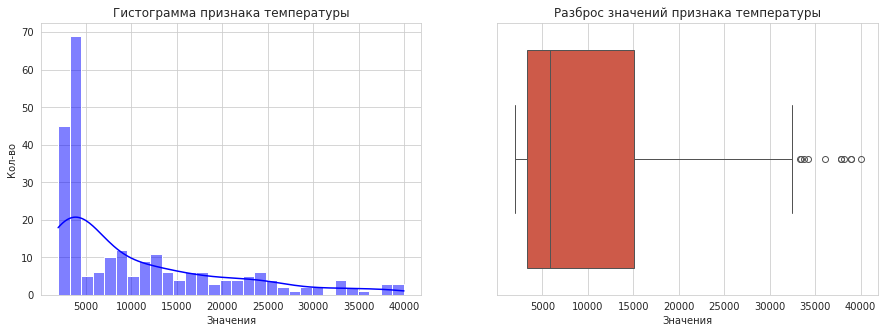

In [29]:
graph_num(df, 'temperature', 'температуры', 'Значения')

In [30]:
print(df['temperature'].quantile(np.linspace(0, 1, 11)))

0.0     1939.0
0.1     2935.0
0.2     3223.6
0.3     3477.7
0.4     3608.8
0.5     5776.0
0.6     9269.0
0.7    12985.8
0.8    18058.0
0.9    24667.0
1.0    40000.0
Name: temperature, dtype: float64


<span style="font-size:30px">**Аналогичное изучение астрономической информации про температуру звезд, показало:**</span>

<span style="font-size:25px">**Подробное описание по типам звезд**</span>

<span style="font-size:20px">**Коричневые карлики и холодные красные карлики (типы 0.0-0.1)**</span>
*   **Температура (K):** 1,939 – 2,935
*   **Объяснение:** Чрезвычайно холодные объекты. Температуры ниже 2,500 K типичны для коричневых карликов — "несостоявшихся звезд", в недрах которых не идут устойчивые термоядерные реакции.

<span style="font-size:20px">**Красные карлики (типы 0.2-0.4)**</span>
*   **Температура (K):** 3,224 – 5,776
*   **Объяснение:** Типичный температурный диапазон для красных карликов — самых распространенных звезд в Галактике. Их низкая температура соответствует малой массе и низкой светимости, но обеспечивает им чрезвычайно долгую жизнь.

<span style="font-size:20px">**Солнцеподобные звезды и гиганты (тип 0.5)**</span>
*   **Температура (K):** 5,776 – 9,269
*   **Объяснение:** Диапазон включает звезды, подобные нашему Солнцу (~5,772 K). Эта температура идеальна для поддержания жизни на планетах земного типа. Сюда же попадают и многие гиганты.

<span style="font-size:20px">**Горячие звезды главной последовательности и белые карлики (тип 0.6)**</span>
*   **Температура (K):** 9,269 – 12,986
*   **Объяснение:** Очень горячие звезды. Сюда входят массивные звезды главной последовательности (класс A), а также молодые, еще не остывшие белые карлики — плотные остатки эволюции звезд.

<span style="font-size:20px">**Сверхгиганты (типы 0.7-0.8)**</span>
*   **Температура (K):** 12,986 – 24,667
*   **Объяснение:** Температура экстремально высока, что характерно для массивных голубых сверхгигантов. Эти звезды являются мощными источниками ультрафиолетового излучения и имеют короткий жизненный цикл.

<span style="font-size:20px">**Гипергиганты (типы 0.9-1.0)**</span>
*   **Температура (K):** 24,667 – 40,000
*   **Объяснение:** Температуры, достигающие 40,000 K, характерны для редчайших и самых массивных гипергигантов. Эти звезды находятся на грани своих возможностей и завершают эволюцию мощнейшим взрывом.

<span style="font-size:25px">**Сводная таблица соответствия**</span>

| Группа | Диапазон температур (K) | Преобладающие типы звезд |
| :--- | :--- | :--- |
| **1** | 1,939 – 2,935 | Коричневые карлики, холодные Красные карлики |
| **2** | 2,935 – 3,224 | Красные карлики (Главная последовательность) |
| **3** | 3,224 – 3,478 | Красные карлики, холодные Гиганты |
| **4** | 3,478 – 5,776 | Главная последовательность (Солнечный тип), Гиганты |
| **5** | 5,776 – 9,269 | Главная последовательность (Горячие), Белые карлики |
| **6** | 9,269 – 12,986 | Главная последовательность (Очень горячие), Белые карлики, Сверхгиганты |
| **7** | 12,986 – 18,058 | Сверхгиганты, Гипергиганты, Главная последовательность (Класс B) |
| **8** | 18,058 – 24,667 | Гипергиганты, Сверхгиганты |
| **9** | 24,667 – 40,000 | Гипергиганты, Сверхгиганты (самые горячие) |

<span style="font-size:30px">**Вывод :**</span>

- **Информация пересекается с предыдущими разделами и соответствует представленным в данных обьектам.**



#### Сводный анализ типов звезд

Рассмотрим сводную таблицу по типам звезд.

In [31]:
df.pivot_table(index='star_type', values=['temperature', 'luminosity', 'radius', 'absolute_magnitude'], aggfunc=['median', 'mean'])

/tmp/ipykernel_329/1547737889.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(index='star_type', values=['temperature', 'luminosity', 'radius', 'absolute_magnitude'], aggfunc=['median', 'mean'])
/tmp/ipykernel_329/1547737889.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(index='star_type', values=['temperature', 'luminosity', 'radius', 'absolute_magnitude'], aggfunc=['median', 'mean'])


median                                       \
          absolute_magnitude    luminosity     radius temperature   
star_type                                                           
0                     17.145       0.00052     0.1060      2935.0   
1                     12.605       0.00315     0.3380      3314.0   
2                     12.340       0.00076     0.0102     13380.0   
3                     -1.180     738.50000     5.7125     12560.5   
4                     -6.235  242145.00000    43.5000     12821.0   
5                     -9.915  266500.00000  1352.5000      3766.0   

                        mean                                          
          absolute_magnitude     luminosity       radius temperature  
star_type                                                             
0                  17.563500       0.000693     0.110015    2997.950  
1                  12.539975       0.005406     0.348145    3283.825  
2                  12.582500       0.002434     0.010728   13931.450  
3                  -0.367425   32067.386275     4.430300   16018.000  
4                  -6.369925  301816.250000    51.150000   15347.850  
5                  -9.654250  309246.525000  1366.897500   11405.700

Посмотрим на количественное распределение типов звезд.

In [32]:
df['star_type'].value_counts()

star_type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64

Такое ровное распределение (40 объектов в каждом из 6 классов) указывает на то, что датасет был сбалансирован искусственно.

<span style="font-size:30px">**Вывод :**</span>


- **Факт искусственного баланса датасета может объяснить резкий взрыв числовых переменных (Luminosity, Radius и Temperature)**

- **Так же возможное обьяснение такого распределия числовых данных в предсталенных переменных ,можно обьяснить пропуском нескольких переходных типов звезд и резким переходом от *карликов* к *гигантам***

- **В целом переданные нам данные соответствуют реальности и могут быть использованы для обучения моделей.**

### Создание новых *фичей* и подготовка старых признаков.

#### Относительный признак Стефана-Больцмана

Создадим признак показывающий, во сколько раз звезда ярче/слабее Солнца

In [33]:
df['stef'] = (df['radius'] ** 2) * ((df['temperature'] / 5778) ** 4)
df.head(5)

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color,stef
0,3068,0.002400,0.1700,16.12,0,red,0.002297
1,3042,0.000500,0.1542,16.60,0,red,0.001827
2,2600,0.000300,0.1020,18.70,0,red,0.000427
3,2800,0.000200,0.1600,16.65,0,red,0.001412
4,1939,0.000138,0.1030,20.06,0,red,0.000135


<span style="font-size:30px">**Вывод :**</span>


- Создали и добавили в обучающий набор, признак отражающий *относительный коэффициент Стефана-Больцмана*

## Оценка корреляции и мультиколлинеальности.

Рассмотрим график корреляции обучающего датасета , при помощи библиотеки phik.

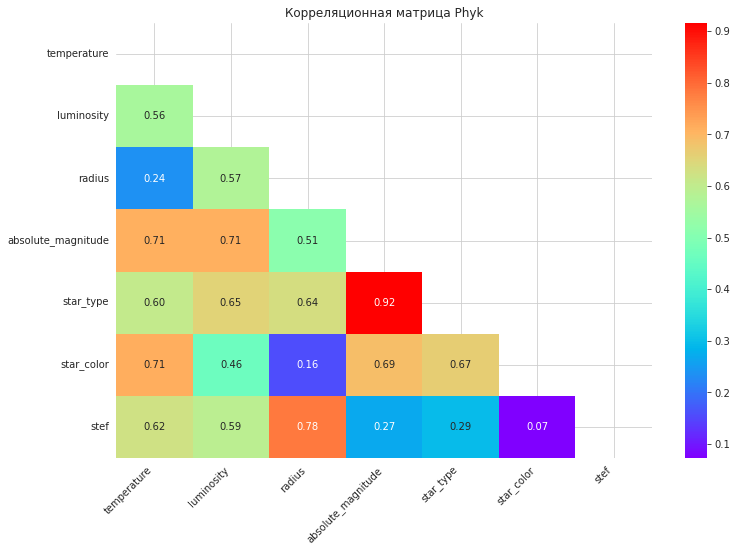

In [34]:
phik_matrix = df.phik_matrix(
    interval_cols=['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'stef'])
tri = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="rainbow", mask=tri);
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.title("Корреляционная матрица Phyk")
plt.show()

Что бы избежать утечки целевого признака , обратимся к индексам VIF.

In [35]:
interval_cols=['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'stef']
vif_num = df[interval_cols].assign(const=1)
vif_data = pd.DataFrame()
vif_data["feature"] = df[interval_cols].columns
vif_data["VIF"] = [variance_inflation_factor(vif_num, i) for i in range(len(df[interval_cols].columns))]
vif_data.sort_values(by="VIF", ascending=False)

,feature,VIF
3,absolute_magnitude,2.836619
2,radius,2.410260
1,luminosity,2.089797
0,temperature,1.812556
4,stef,1.630551


In [36]:
df.columns

Index(['temperature', 'luminosity', 'radius', 'absolute_magnitude',
       'star_type', 'star_color', 'stef'],
      dtype='object')

### Вывод

- Несмотря на высокий индекс корреляции между **absolute_magnitude** и **star_type** примем решение оставить оба признака , так как один признак числовой а второй несмотря на то что представлен в числовом виде носит категориальный характер.

- Проверка на мультиколлинеальность не выявила утечки какого либо признака.

## Обучение модели.

### Обработка датасета

Перед передачей модели обучающего датасета , отмаштабируем и закодируем признаки.

In [37]:
cat_cols = ['star_type', 'star_color']
num_cols = ['luminosity', 'radius', 'absolute_magnitude', 'stef']
num_cols , cat_cols

(['luminosity', 'radius', 'absolute_magnitude', 'stef'],
 ['star_type', 'star_color'])

In [38]:
ohe = OneHotEncoder(drop='first', sparse_output=False)
ohe_result = ohe.fit_transform(df[cat_cols])
df_ohe = pd.DataFrame(ohe_result, columns=ohe.get_feature_names_out(cat_cols))
df_ohe.head(5)

,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue_white,star_color_orange,star_color_red,star_color_white,star_color_yellow_white,star_color_yellowish
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [39]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]),columns=num_cols,index=df.index)
df_scaled.head(5)

,luminosity,radius,absolute_magnitude,stef
0,-0.598624,-0.459210,1.116745,-0.158738
1,-0.598624,-0.459241,1.162414,-0.158738
2,-0.598624,-0.459342,1.362213,-0.158738
3,-0.598624,-0.459229,1.167171,-0.158738
4,-0.598624,-0.459340,1.491607,-0.158738


In [40]:
df_fin = pd.concat([df_scaled, df_ohe], axis=1)
df_fin.head(5)

,luminosity,radius,absolute_magnitude,stef,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue_white,star_color_orange,star_color_red,star_color_white,star_color_yellow_white,star_color_yellowish
0,-0.598624,-0.459210,1.116745,-0.158738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.598624,-0.459241,1.162414,-0.158738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.598624,-0.459342,1.362213,-0.158738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.598624,-0.459229,1.167171,-0.158738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.598624,-0.459340,1.491607,-0.158738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [41]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   luminosity               240 non-null    float64
 1   radius                   240 non-null    float64
 2   absolute_magnitude       240 non-null    float64
 3   stef                     240 non-null    float64
 4   star_type_1              240 non-null    float64
 5   star_type_2              240 non-null    float64
 6   star_type_3              240 non-null    float64
 7   star_type_4              240 non-null    float64
 8   star_type_5              240 non-null    float64
 9   star_color_blue_white    240 non-null    float64
 10  star_color_orange        240 non-null    float64
 11  star_color_red           240 non-null    float64
 12  star_color_white         240 non-null    float64
 13  star_color_yellow_white  240 non-null    float64
 14  star_color_yellowish     2

In [42]:
df_fin.shape

(240, 15)

### Создание обучающей и тестовой выборки.

In [43]:
X = df_fin
y = df['temperature'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS) 

**Перевод данных в тензоры**

In [44]:
X_train = torch.FloatTensor(X_train.to_numpy())
X_test = torch.FloatTensor(X_test.to_numpy())
y_train = torch.FloatTensor(y_train.to_numpy()).reshape(-1, 1)  
y_test = torch.FloatTensor(y_test.to_numpy()).reshape(-1, 1) 

### Baseline модель


В качестве базовой версии используем модель с 2 скрытыми слоями.

Для оценки эффектности модели будем использовать метрику RMSE.

In [45]:
n_in_neurons = 15
n_hidden_neurons_1 = 32
n_hidden_neurons_2 = 16
n_out_neurons = 1

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
)

In [46]:
# n_in_neurons = 14
# n_hidden_neurons_1 = 64
# n_hidden_neurons_2 = 32
# n_hidden_neurons_3 = 16
# n_hidden_neurons_4 = 8
# n_out_neurons = 1

# net = nn.Sequential(
#     nn.Linear(n_in_neurons, n_hidden_neurons_1),
#     nn.ReLU(),
#     nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
#     nn.ReLU(),
#     nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
#     nn.ReLU(),
#     nn.Linear(n_hidden_neurons_3, n_out_neurons),
# )

In [47]:
best_test_rmse = float('inf')
best_model_state = None

In [48]:
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 15000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net.forward(X_train)
    loss_value = mse_loss(preds, y_train)
    loss_value.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        net.eval()
        
        train_rmse = torch.sqrt(mse_loss(net.forward(X_train), y_train))
        test_rmse = torch.sqrt(mse_loss(net.forward(X_test), y_test))
            
        print(f'Epoch {epoch}: Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}')

        if test_rmse < best_test_rmse:
            best_test_rmse = test_rmse
            best_model_state = net.state_dict().copy()  

Epoch 0: Train RMSE = 14027.3604, Test RMSE = 14626.6582
Epoch 1000: Train RMSE = 10528.2295, Test RMSE = 11142.7695
Epoch 2000: Train RMSE = 6398.9688, Test RMSE = 6831.9092
Epoch 3000: Train RMSE = 5869.2339, Test RMSE = 6100.1094
Epoch 4000: Train RMSE = 5469.8018, Test RMSE = 5661.7007
Epoch 5000: Train RMSE = 4954.4595, Test RMSE = 5084.1343
Epoch 6000: Train RMSE = 4344.7822, Test RMSE = 4417.2246
Epoch 7000: Train RMSE = 3971.8005, Test RMSE = 4071.3157
Epoch 8000: Train RMSE = 3817.4500, Test RMSE = 3980.3147
Epoch 9000: Train RMSE = 3707.8362, Test RMSE = 3921.9363
Epoch 10000: Train RMSE = 3603.7346, Test RMSE = 3911.3650
Epoch 11000: Train RMSE = 3479.9934, Test RMSE = 3965.2996
Epoch 12000: Train RMSE = 3325.6970, Test RMSE = 4146.1733
Epoch 13000: Train RMSE = 3103.8748, Test RMSE = 4522.6318
Epoch 14000: Train RMSE = 2865.5515, Test RMSE = 5306.2705


Загрузим модель с лучшим результатом на тестовом наборе данных и получим предсказания для дальнейшего построения графиков.

In [49]:
net.load_state_dict(best_model_state)
net.eval()  

with torch.no_grad():
    train_predictions = net(X_train)
    test_predictions = net(X_test)

In [50]:
test_predictions_np = test_predictions.detach().numpy().flatten()
y_test_graph = y_test.detach().numpy().flatten()

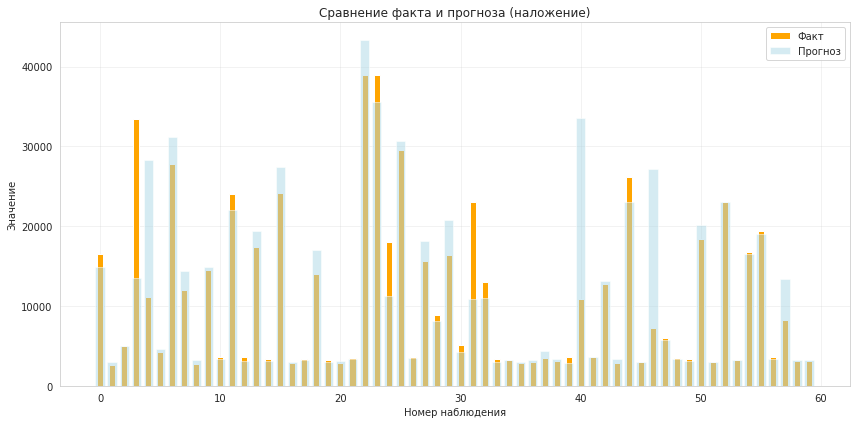

In [51]:
y_test_array = y_test_graph
test_predictions_array = test_predictions_np

df = pd.DataFrame({
    'Номер_наблюдения': np.arange(len(y_test_array)),
    'Факт': y_test_array,
    'Прогноз': test_predictions_array
})

plt.figure(figsize=(12, 6))

x_pos = np.arange(len(df))

plt.bar(x_pos, df['Факт'], 0.5, alpha=1, label='Факт', color='orange')
plt.bar(x_pos, df['Прогноз'], 0.8, alpha=0.5, label='Прогноз', color='lightblue')

plt.title('Сравнение факта и прогноза (наложение)')
plt.xlabel('Номер наблюдения')
plt.ylabel('Значение')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Вывод

- При обучении базовой версии модели , удалось достичь результата Train RMSE = 3603.7581, Test RMSE = 3911.2900. Что соответствует требованиям заказчика.

- Продолжим дальнейшее усложнение модели и посмотрим удастся ли улучшить результат.

### Giga_pipeline

Усложним нашу модель добавив методы batch и dropout.

In [52]:
# Пайплайн отрабатывает ~+-12 минут ,что бы не ждать добавил результаты наперед.

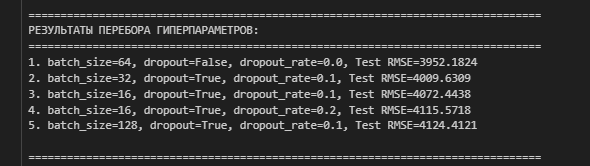

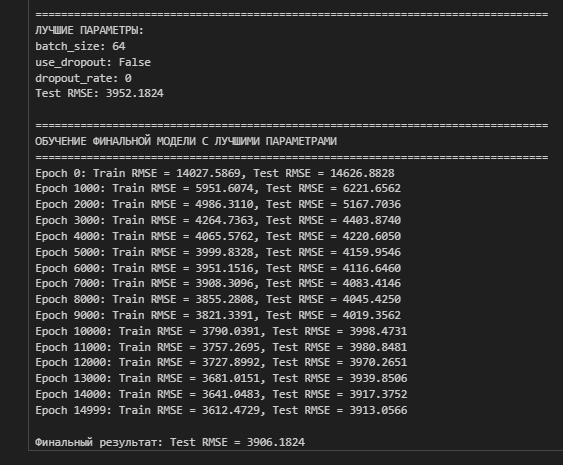

In [ ]:
# RMSE
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, pred, target):
        return torch.sqrt(self.mse(pred, target))

# Функция для создания модели с dropout (бэйслайн сетап)
def create_model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, 
                 with_dropout=False, dropout_rate=0.2):
    if with_dropout:
        return nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons_1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_rate),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(n_hidden_neurons_2, n_out_neurons),
        )
    else:
        return nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons_1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_2, n_out_neurons),
        )

# Функция для обучения модели
def train_model(model, train_loader, test_loader, num_epochs=10000, learning_rate=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = RMSELoss()
    
    best_test_rmse = float('inf')
    best_epoch = 0
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            preds = model(batch_X)
            loss_value = loss_fn(preds, batch_y)
            loss_value.backward()
            optimizer.step()
            epoch_loss += loss_value.item()
        
        if epoch % 100 == 0 or epoch == num_epochs - 1:
            model.eval()
            with torch.no_grad():
                # RMSE на тренировочных данных
                train_preds = []
                train_targets = []
                for batch_X, batch_y in train_loader:
                    batch_preds = model(batch_X)
                    train_preds.append(batch_preds)
                    train_targets.append(batch_y)
                
                train_preds = torch.cat(train_preds)
                train_targets = torch.cat(train_targets)
                train_rmse = loss_fn(train_preds, train_targets)
                
                # RMSE на тестовых данных
                test_preds = []
                test_targets = []
                for batch_X, batch_y in test_loader:
                    batch_preds = model(batch_X)
                    test_preds.append(batch_preds)
                    test_targets.append(batch_y)
                
                test_preds = torch.cat(test_preds)
                test_targets = torch.cat(test_targets)
                test_rmse = loss_fn(test_preds, test_targets)
                
                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse
                    best_epoch = epoch
            
            if epoch % 1000 == 0 or epoch == num_epochs - 1:
                print(f'Epoch {epoch}: Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}')
    
    return best_test_rmse.item(), best_epoch

# Перебор параметров
def hyperparameter_search(X_train, y_train, X_test, y_test):
    batch_sizes = [16, 32, 64, 128]
    dropout_options = [False, True]
    dropout_rates = [0.1, 0.2, 0.3] if True in dropout_options else [0]
    
    # Сохраняем наш бейслайн
    n_in_neurons = X_train.shape[1]
    n_hidden_neurons_1 = 32
    n_hidden_neurons_2 = 16
    n_out_neurons = y_train.shape[1] if len(y_train.shape) > 1 else 1
    
    best_params = None
    best_test_rmse = float('inf')
    results = []
    
    print("Начинаем перебор гиперпараметров...")
    print("=" * 80)
    
    for batch_size in batch_sizes:
        # Создаем DataLoader для текущего размера батча
        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)
        
        for use_dropout in dropout_options:
            if use_dropout:
                dropout_rates_to_try = dropout_rates
            else:
                dropout_rates_to_try = [0]  
            
            for dropout_rate in dropout_rates_to_try:
                print(f"\nТестируем: batch_size={batch_size}, dropout={use_dropout}, dropout_rate={dropout_rate}")
                
                # Создаем DataLoader с текущим размером батча
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
                
                # Создаем и обучаем модель
                model = create_model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons,
                                   with_dropout=use_dropout, dropout_rate=dropout_rate)
                test_rmse, best_epoch = train_model(model, train_loader, test_loader)
                
                results.append({
                    'batch_size': batch_size,
                    'use_dropout': use_dropout,
                    'dropout_rate': dropout_rate,
                    'test_rmse': test_rmse,
                    'best_epoch': best_epoch
                })
                
                print(f"Результат: Test RMSE = {test_rmse:.4f} (лучшая эпоха: {best_epoch})")
                
                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse
                    best_params = {
                        'batch_size': batch_size,
                        'use_dropout': use_dropout,
                        'dropout_rate': dropout_rate,
                        'test_rmse': test_rmse
                    }
    
    # Выводим результаты
    print("\n" + "=" * 80)
    print("РЕЗУЛЬТАТЫ ПЕРЕБОРА ГИПЕРПАРАМЕТРОВ:")
    print("=" * 80)
    
    # Сортируем результаты по качеству
    results.sort(key=lambda x: x['test_rmse'])
    
    for i, result in enumerate(results[:5]):
        print(f"{i+1}. batch_size={result['batch_size']}, "
              f"dropout={result['use_dropout']}, "
              f"dropout_rate={result['dropout_rate']:.1f}, "
              f"Test RMSE={result['test_rmse']:.4f}")
    
    print("\n" + "=" * 80)
    print("ЛУЧШИЕ ПАРАМЕТРЫ:")
    print(f"batch_size: {best_params['batch_size']}")
    print(f"use_dropout: {best_params['use_dropout']}")
    print(f"dropout_rate: {best_params['dropout_rate']}")
    print(f"Test RMSE: {best_params['test_rmse']:.4f}")
    
    return best_params, results

if __name__ == "__main__":
     
    # Запускаем поиск гиперпараметров
    best_params, all_results = hyperparameter_search(X_train, y_train, X_test, y_test)
    
    print("\n" + "=" * 80)
    print("ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ С ЛУЧШИМИ ПАРАМЕТРАМИ")
    print("=" * 80)
    
    # Бейслайн параметры
    n_in_neurons = X_train.shape[1]
    n_hidden_neurons_1 = 32
    n_hidden_neurons_2 = 16
    n_out_neurons = y_train.shape[1] if len(y_train.shape) > 1 else 1
    
    # Создаем DataLoader с лучшими параметрами
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)
    
    # Создаем и обучаем финальную модель
    final_model = create_model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons,
                             with_dropout=best_params['use_dropout'], 
                             dropout_rate=best_params['dropout_rate'])
    
    # Обучаем на большем количестве эпох для лучшего результата
    final_test_rmse, final_best_epoch = train_model(final_model, train_loader, test_loader, num_epochs=15000)
    
    print(f"\nФинальный результат: Test RMSE = {final_test_rmse:.4f}")

Начинаем перебор гиперпараметров...

Тестируем: batch_size=16, dropout=False, dropout_rate=0
Epoch 0: Train RMSE = 14027.3096, Test RMSE = 14626.6074
Epoch 1000: Train RMSE = 4356.2139, Test RMSE = 4602.6646
Epoch 2000: Train RMSE = 3982.1016, Test RMSE = 4140.8267
Epoch 3000: Train RMSE = 3823.6826, Test RMSE = 4081.1582
Epoch 4000: Train RMSE = 3737.2776, Test RMSE = 4064.5618
Epoch 5000: Train RMSE = 3656.1147, Test RMSE = 4101.8047
Epoch 6000: Train RMSE = 3586.4783, Test RMSE = 4079.6682
Epoch 7000: Train RMSE = 3518.4883, Test RMSE = 4050.8274
Epoch 8000: Train RMSE = 3458.9341, Test RMSE = 4044.3491
Epoch 9000: Train RMSE = 3401.8511, Test RMSE = 4068.9478
Epoch 9999: Train RMSE = 3346.5071, Test RMSE = 4089.7322
Результат: Test RMSE = 4028.3010 (лучшая эпоха: 7100)

Тестируем: batch_size=16, dropout=True, dropout_rate=0.1
Epoch 0: Train RMSE = 14027.5654, Test RMSE = 14626.8633
Epoch 1000: Train RMSE = 4758.8594, Test RMSE = 4997.6162
Epoch 2000: Train RMSE = 4130.7246, Test RM

Проделаем аналогичный шаг по получению предсказаний и построению графиков.

In [54]:
giga_pred = final_model.forward(X_test)
giga_predictions_np = giga_pred.detach().numpy().flatten()

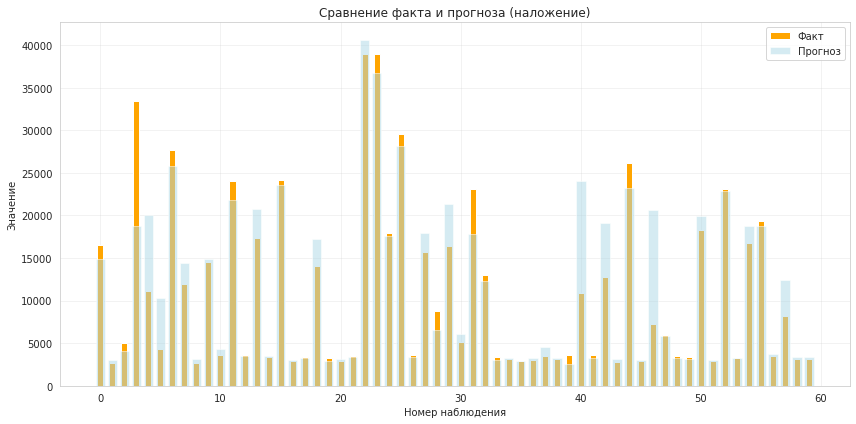

In [55]:
y_test_array = y_test_graph
test_predictions_array = giga_predictions_np

df = pd.DataFrame({
    'Номер_наблюдения': np.arange(len(y_test_array)),
    'Факт': y_test_array,
    'Прогноз': test_predictions_array
})

plt.figure(figsize=(12, 6))

x_pos = np.arange(len(df))

plt.bar(x_pos, df['Факт'], 0.5, alpha=1, label='Факт', color='orange')
plt.bar(x_pos, df['Прогноз'], 0.8, alpha=0.5, label='Прогноз', color='lightblue')

plt.title('Сравнение факта и прогноза (наложение)')
plt.xlabel('Номер наблюдения')
plt.ylabel('Значение')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Вывод

- В ходе длительного перебора возможных гиперпараметров , удалось добиться улучшения функции потерь **RMSE** до **3906** , добавив следующие параметры : **batch_size: 64 , use_dropout: False , dropout_rate: 0** к нашей базовой версии нейросети.

## Сравнительный обзор графиков.

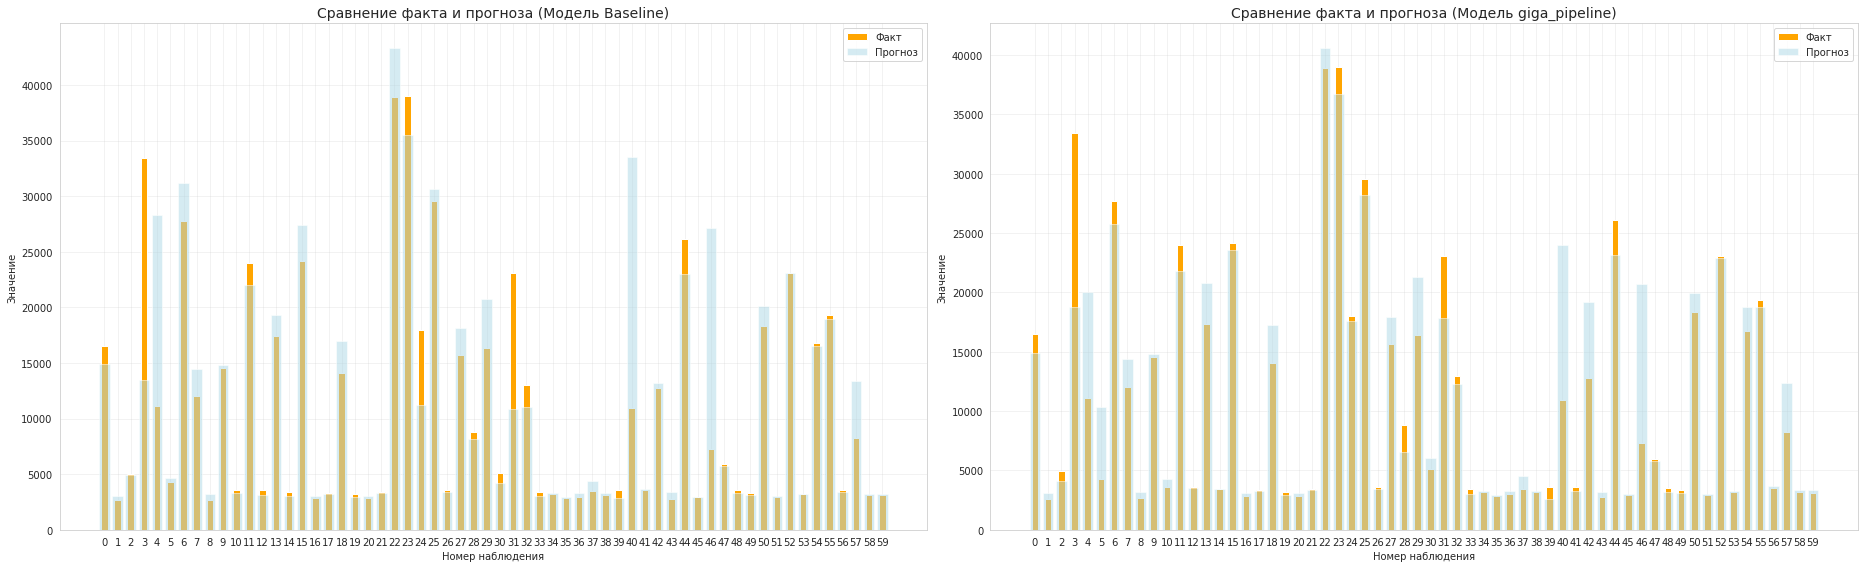

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 8))

# Первый график
y_test_array = y_test_graph
test_predictions_array = test_predictions_np

df1 = pd.DataFrame({
    'Номер_наблюдения': np.arange(len(y_test_array)),
    'Факт': y_test_array,
    'Прогноз': test_predictions_array
})

x_pos1 = np.arange(len(df1))

ax1.bar(x_pos1, df1['Факт'], 0.5, alpha=1, label='Факт', color='orange')
ax1.bar(x_pos1, df1['Прогноз'], 0.8, alpha=0.5, label='Прогноз', color='lightblue')

ax1.set_title('Сравнение факта и прогноза (Модель Baseline)', fontsize=14)
ax1.set_xlabel('Номер наблюдения')
ax1.set_ylabel('Значение')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(np.arange(0, len(df1), 1))  
ax1.set_yticks(np.arange(0, max(df1['Прогноз']), 5000))

# Второй график
y_test_array = y_test_graph
test_predictions_array = giga_predictions_np

df2 = pd.DataFrame({
    'Номер_наблюдения': np.arange(len(y_test_array)),
    'Факт': y_test_array,
    'Прогноз': test_predictions_array
})

x_pos2 = np.arange(len(df2))

ax2.bar(x_pos2, df2['Факт'], 0.5, alpha=1, label='Факт', color='orange')
ax2.bar(x_pos2, df2['Прогноз'], 0.8, alpha=0.5, label='Прогноз', color='lightblue')

ax2.set_title('Сравнение факта и прогноза (Модель giga_pipeline)', fontsize=14)
ax2.set_xlabel('Номер наблюдения')
ax2.set_ylabel('Значение')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(np.arange(0, len(df1), 1))  
ax2.set_yticks(np.arange(0, max(df1['Прогноз']), 5000))

plt.tight_layout()
plt.show()

## Финальный вывод.

Мы получили задачу от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд , вот чего удалось достичь в ходе исследования :

- Мы загрузили присланные заказчиком данные , это был небольшого размера датасет (240х6) с некоторыми незначительными дефектами.

- На этапе предобработки мы занялись улучшением и обработкой дефектов в данных а именно :

    * Избавились от неинформативного столбца **Unnamed: 0** который содержал аналогичную pandas индексацию.

    * Привели названия переменных к общепринятому стандарту.

    * Обработали значения переменной **star_color** избавившись от смысловых дубликатов.

- На этапе анализа мы заметили сильный перекос данных в сторону нуля. Но в ходе более детального ознакомления с астрономической спецификой , мы пришли к выводу о полном соответствии данных реальным значениям.

- Так же нами был обнаружена *отфильтрованная* природа нашего датасета , так как было представлено ровно по 40 значений каждого типа звезд. Что как раз таки объясняет большой *взрыв* количественных переменных , так как возможно были упущенны переходные типа звезд между *карликами* и *сверхгигантами*.

- Так же мы создали дополнительный признак *относительный* коэффициент Стефана-Больцмана , так как обсерватория использовала его в своих исследованиях , а так же это помогло в скорости схождения модели.

- Оценка корреляции и мультиколлениральности , не выявила помех для передачи нашей выборки в модель для обучения.

- В ходе блока обучения модели , мы достигли следующих результатов :

    * Обучили базовую модель нейросети без использования методов регуляризации данных. Получив следующий результат **Train RMSE = 3603, Test RMSE = 3911** , при заданной заказчиком планке в RMMSE = 4500.

    * Создали пайплайн для перебора всех доступных нам на данный момент гиперпараметров нейросети. Достигнув улучшения метрики **RMSE** до **3906** на тестовой выборке , при следующих параметрах **batch_size: 64 , use_dropout: False , dropout_rate: 0**.


<span style="font-size:20px">Несмотря на *большой* разброс в числовых переменных базовая модель показала практически тот же уровень предсказаний что и модель с параметрами регурелизации. </span>



## Рекомендации

- Для последующего улучшения предсказаний модели , заказчику необходимо увеличить кол-во наблюдений и добавить в датасет несколько *переходных* типов звезд , для большей точности и плавности работы модели.